- zqのMSEを調べる
- 学習データのbook_indicesの最頻値からzqを取得
- テストデータのzqのMSEを計算

In [1]:
%cd /raid6/home/yokoyama/har-for-or/
import os
import sys
from glob import glob
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm

sys.path.append(".")
from src.model import CSQVAE
from src.utils import yaml_handler, vis

/raid6/home/yokoyama/har-for-or


/raid6/home/yokoyama/har-for-or/.venv/lib/python3.10/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


In [2]:
# test
model_type = "sqvae"
dataset_num = 3
# if dataset_num == 3:
#     v = 0
# elif dataset_num == 4:
#     v = 1
# elif dataset_num == 5:
#     v = 2
v = 0
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
test_video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride
if config.mask_leg:
    n_pts = 13 + 2
else:
    n_pts = 17 + 2

# load preds
data_root = f"../datasets/dataset{dataset_num:02d}/test/{test_video_num:02d}"
paths = glob(os.path.join(data_root, f"pred_{model_type}", "*"))
results = []
for path in paths:
    with open(path, "rb") as f:
        results.append(pickle.load(f))

img_dir = f"../datasets/dataset{dataset_num:02d}/images"
os.makedirs(img_dir, exist_ok=True)

In [3]:
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))

results = {}
for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))
    if int(video_num) != test_video_num:
        continue

    # load preds
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            result = pickle.load(f)
            results[result["key"]] = result

100%|██████████| 19/19 [00:00<00:00, 26.52it/s]


In [29]:
n_frame = 49500
_id = 657
target_key = f"{test_video_num:02d}_{n_frame}_{_id}"
result = results[target_key]

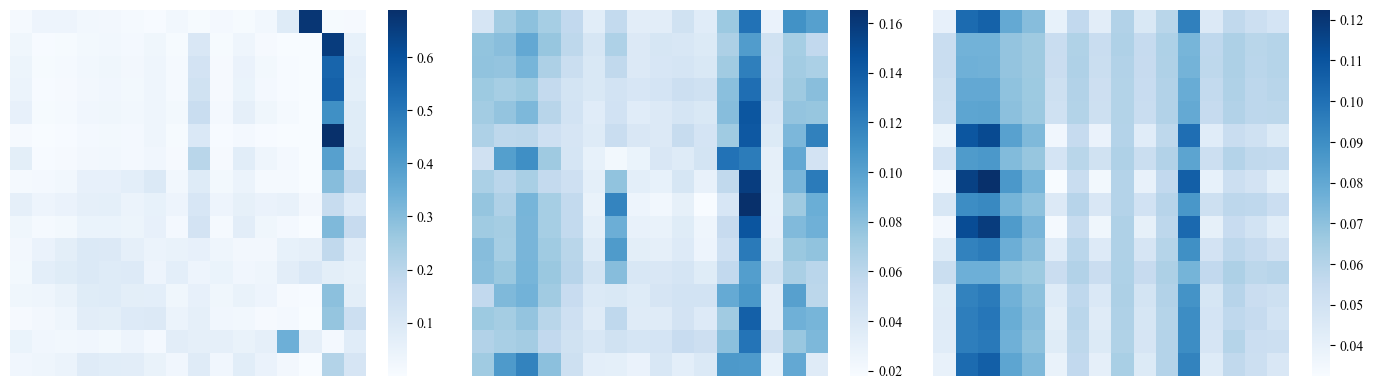

In [30]:
def attention_heatmap_clustering(result, n_layers):
    fig = plt.figure(figsize=(14, 4))
    axs = fig.subplots(1, n_layers)
    attn_w = result["attn_w_cls"]
    for i in range(n_layers):
        sns.heatmap(
            attn_w[i],
            annot=False,
            cmap="Blues",
            ax=axs[i],
            cbar=True,
            xticklabels=False,
            yticklabels=False,
        )

    fig.tight_layout()
    plt.show()


attention_heatmap_clustering(result, config.nlayers)

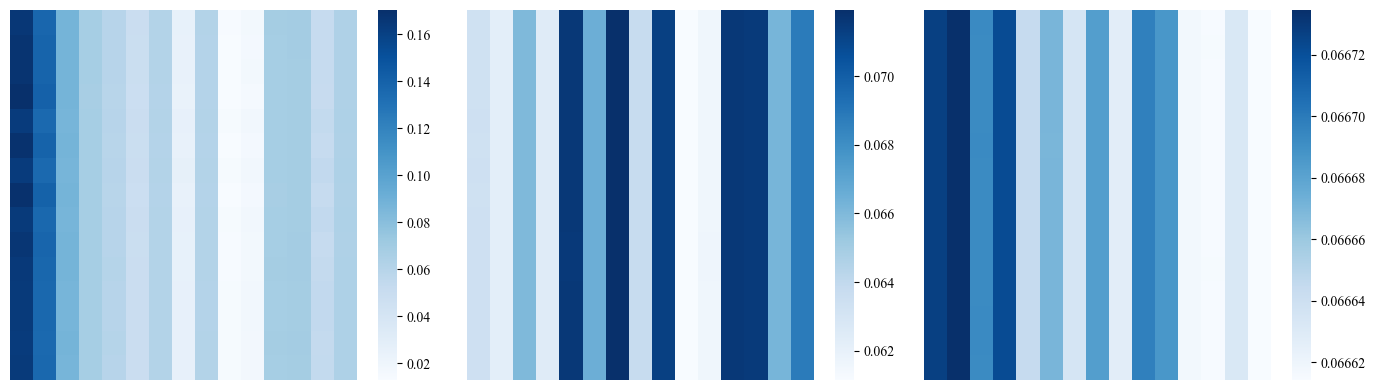

In [31]:
def attention_heatmap(result, n_layers):
    fig = plt.figure(figsize=(14, 4))
    axs = fig.subplots(1, n_layers)
    attn_w = result["attn_w"]
    for i in range(n_layers):
        sns.heatmap(
            attn_w[i],
            annot=False,
            cmap="Blues",
            ax=axs[i],
            cbar=True,
            xticklabels=False,
            yticklabels=False,
        )

    fig.tight_layout()
    plt.show()


attention_heatmap(result, config.nlayers)

In [32]:
gpu_id = 1
device = f"cuda:{gpu_id}"

# load model
model = SQVAE(config)
model.configure_model()
model = model.to(device)

checkpoint_path = sorted(glob(f"{checkpoint_dir}/*.ckpt"))[-1]
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"])


books = {i: book.detach().cpu().numpy() for i, book in enumerate(model.quantizer.books)}
X = np.array([book for book in books.values()]).reshape(-1, config.latent_ndim)
labels = np.array(
    [[c for _ in range(config.book_size)] for c in range(config.n_clusters)]
).ravel()

In [33]:
point_texts = {
    0: ["nose", (-100, 75)],
    1: ["l_eye", (-87.5, 85)],
    2: ["r_eye", (-75, 75)],
    3: ["l_ear", (-62.5, 85)],
    4: ["r_ear", (-50, 75)],
    5: ["l_shoulder", (-37.5, 85)],
    6: ["r_shoulder", (-25, 75)],
    7: ["l_elbow", (-12.5, 85)],
    8: ["l_wrist", (0, 75)],
    9: ["r_elbow", (12.5, 85)],
    10: ["r_wrist", (25, 75)],
    11: ["l_hip", (37.5, 85)],
    12: ["r_hip", (50, 75)],
    13: ["bbox1", (62.5, 85)],
    14: ["bbox2", (75, 75)],
}

In [34]:
target_label = result["label"]
target_book_idxs = result["book_idx"]
target_book_idxs

array([ 19, 453,  19,  15,  19, 445,  19, 445,  19, 445, 445,  19,  19,  19,  19])

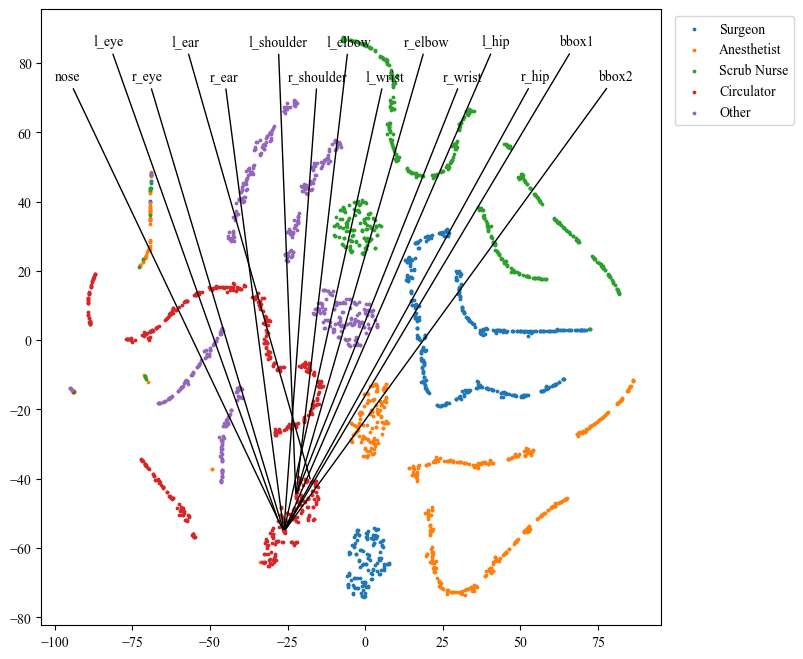

In [35]:
from sklearn.manifold import TSNE


def plot_tsne(
    target_label,
    target_book_idxs,
    X,
    labels,
    classes,
    perplexity=10,
    figpath=None,
    is_show=False,
    cmap="tab10",
    lut=None,
    legend=True,
):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    embedded = tsne.fit_transform(X)
    unique_labels = np.unique(labels)
    cm = plt.get_cmap(cmap, lut)
    plt.figure(figsize=(8, 8))
    for label in unique_labels:
        x = embedded[labels == label]
        if lut is not None:
            ci = np.where(unique_labels == label)[0].item()
        else:
            ci = int(label)
        c = cm(ci)
        plt.scatter(x.T[0], x.T[1], s=3, c=c, label=classes[label])

        if label == target_label:
            for i, idx in enumerate(target_book_idxs):
                xi = x.T[0, idx]
                yi = x.T[1, idx]
                txt = point_texts[i][0]
                txt_xy = point_texts[i][1]
                plt.annotate(
                    txt,
                    (xi, yi),
                    txt_xy,
                    arrowprops=dict(
                        arrowstyle="-",
                        # width=0.05,
                        # headwidth=0.05,
                        # headlength=0.05,
                        connectionstyle="arc3",
                        facecolor="black",
                        edgecolor="black",
                    ),
                )
    if legend:
        plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    if figpath is not None:
        plt.savefig(figpath, bbox_inches="tight", dpi=300)
    if is_show:
        plt.show()
    plt.close()


plot_tsne(
    target_label, target_book_idxs, X, labels, classes, is_show=True, cmap="tab10"
)

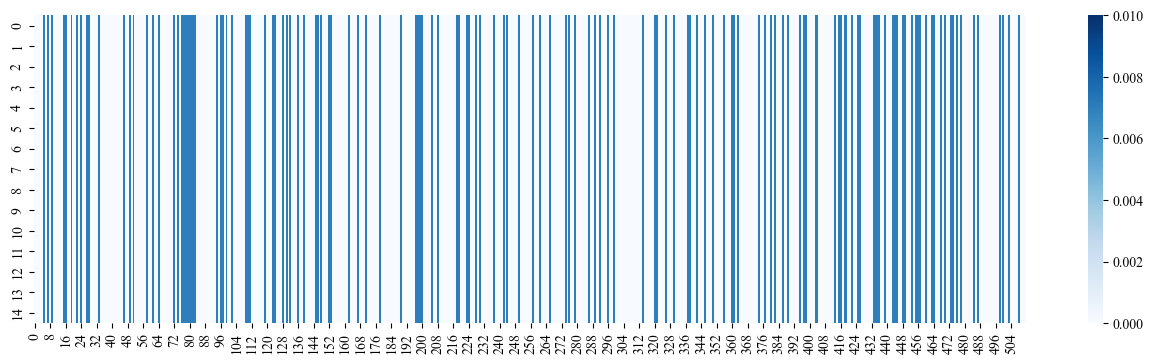

0.0070282533 0.0019531248 0.0031430242
0.007029016 0.001953125 0.0031430249
0.0070282393 0.0019531248 0.0031430232
0.00702814 0.001953125 0.0031430249
0.007029055 0.0019531249 0.0031430193
0.0070290067 0.001953125 0.003143023
0.0070291334 0.0019531252 0.0031430188
0.007028971 0.0019531248 0.003143023
0.0070291213 0.0019531252 0.003143019
0.0070289527 0.001953125 0.0031430232
0.007029055 0.0019531252 0.003143023
0.0070294887 0.001953125 0.0031430183
0.0070294887 0.001953125 0.0031430183
0.0070290943 0.0019531252 0.003143021
0.0070290975 0.001953125 0.0031430193


In [36]:
heatmap = result["book_prob"]
plt.figure(figsize=(16, 4))
sns.heatmap(heatmap, cmap="Blues", vmin=0.0, vmax=0.01)
plt.show()
for i in range(heatmap.shape[0]):
    print(np.max(heatmap[i]), np.mean(heatmap[i]), np.std(heatmap[i]))